In [1]:
# Imports All relevant libraries
from super_func import *


In [2]:
# opens the file to the api keys saved as creds
with open('.hidden/creds.json') as f:
    creds = json.load(f)

In [3]:
# Sets variables for url_params
term = 'Pet Store'
location = 'Queens'
limit = 50
offset = 0
# Sets variables for csv file names for business
csv_filename = './csv/petstores.csv'
csv_filepath = './csv/petstores.csv'
# Sets variables for csv file names for reviews
reviews_filename = './csv/reviews.csv'

In [4]:
# Url argument
url_params = {'term': term,
        'location': location,
        'limit': limit,
        'offset': offset}

In [5]:
# Deletes the current csv file 
if os.path.isfile(csv_filename):
    os.remove(csv_filename)
# Deletes the current csv file 
if os.path.isfile(csv_filename):
    os.remove(csv_filename)

In [6]:
# create a variable  to keep track of which result you are in. 
cur = 0
num = 500
#set up a while loop to go through and grab the result 
while cur < num and cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url_params, creds)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    df_save(parsed_results, str(csv_filename))
    #increment the counter by 50 to move on to the next results
    cur += 50

In [7]:
# Lets you store the csv in a pandas DF
pet_stores_load = pd.read_csv('./csv/petstores.csv', index_col=0)
pet_stores = pet_stores_load[pet_stores_load['alias'] == 'petstore']


In [8]:
# Gets the business_ids, business_ids_names, business_names with the BID funcion
business_ids, business_ids_names, business_names = business_ids_get()

In [9]:
# Pulls the yelp reviews foe each business
reviews = yelp_call_reviews(creds, business_ids)

In [10]:
# Makes a list out of the reviews and associated columns
list_of_reviews = list_of_reviews(reviews,business_ids, business_ids_names, business_names)

In [11]:
#Creates a review data fram and filters out the coloms that are needed, to make a new data frame
reviews_df = pd.DataFrame(list_of_reviews)
reviews_selection = reviews_df[['business_id', 'text_excerpt', 'review_url',  'time_created', 'user_name']]
reviews_cleaned = reviews_selection.rename(columns={"business_id": "id"}) # Changes the column value to match the pet store dataframe 

In [12]:
# Deletes the current csv file 
if os.path.isfile(reviews_filename):
    os.remove(reviews_filename)

In [13]:
# Saves the reviews df to a csv file
df_save(reviews_cleaned, reviews_filename)

In [14]:
# Opens the relevant CSV
pet_stores_csv = pd.read_csv('./csv/petstores.csv', index_col= 0)
reviews_csv = pd.read_csv('./csv/reviews.csv', index_col= 0)

In [15]:
# Merges the 
merged_result = pd.merge(pet_stores, reviews_csv, on="id")

**The Map**

In [16]:
# Creates a base map layout
base_map = folium.Map([lat,long] , zoom_start=11)

In [17]:
# Filters out geometrics and data
Qresults = merged_result[merged_result['zip'].isin(Qzips)]
Mresults = merged_result[merged_result['zip'].isin(Mzips)]

vet_zips = pd.read_csv('./csv/vets.csv')

VQresults = vet_zips[vet_zips['zip_code'].isin(Qzips)]
VMresults = vet_zips[vet_zips['zip_code'].isin(Mzips)]

Result_points = merged_result[merged_result['zip'].astype(str).str.contains('10021')]
VResult_points = vet_zips[vet_zips['zip_code'].astype(str).str.contains('10021')]

In [18]:
# Queens Points
QPoints = folium.FeatureGroup(name='Queens', show=True)
base_map.add_child(QPoints)

for (index, row) in Qresults.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['name'], 
                  icon=folium.Icon(color='blue', icon='fa-cart-plus', prefix='fa'),
                  tooltip='click').add_to(QPoints)

for (index, row) in VQresults.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['business_name'], 
                  icon=folium.Icon(color='pink', icon='fa-heart', prefix='fa'),
                  tooltip='click').add_to(QPoints)
# Manhattan Points 
MPoints = folium.FeatureGroup(name='Manhattan', show=True)
base_map.add_child(MPoints)

for (index, row) in Mresults.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['name'], 
                  icon=folium.Icon(color='blue', icon='fa-cart-plus', prefix='fa'),
                  tooltip='click').add_to(MPoints)

for (index, row) in VMresults.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['business_name'], 
                  icon=folium.Icon(color='pink', icon='fa-heart', prefix='fa'),
                  tooltip='click').add_to(MPoints)

#Result Points
RPoints = folium.FeatureGroup(name='Result', show=False)
base_map.add_child(RPoints)

for (index, row) in Result_points.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['name'], 
                  icon=folium.Icon(color='blue', icon='fa-cart-plus', prefix='fa'),
                  tooltip='click').add_to(RPoints)

for (index, row) in VResult_points.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], 
                  popup=row.loc['business_name'], 
                  icon=folium.Icon(color='pink', icon='fa-heart', prefix='fa'),
                  tooltip='click').add_to(RPoints)

# Extra Functionality
folium.GeoJson(geo_data_Q, name='Queens').add_to(QPoints)
folium.GeoJson(geo_data_M, name='Manhattan').add_to(MPoints)
folium.GeoJson(geo_data_r, name='Result').add_to(RPoints)
folium.raster_layers.TileLayer('Open Street Map').add_to(base_map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(base_map)
folium.LayerControl().add_to(base_map)
plugins.ScrollZoomToggler().add_to(base_map)

In [19]:
base_map
    

In [20]:
# Deltes the map file 
if os.path.isfile('map.html'):
    os.remove('map.html')

In [21]:
# Cretaes a new map html file
output_file = "map.html"
base_map.save(output_file)

** EDA and Graphs ** 

In [ ]:
# dogparksinNYzipcodes.to_csv('ActualDogParksManhattanZipcodes.csv', header='column_names', index = 0)

In [22]:
# Opens the relevant csv files
DogParks_Queens_DF = pd.read_csv('./csv/ActualDogParksQueensZipcodes.csv')
DogParks_Manhattan_DF = pd.read_csv('./csv/ActualDogParksManhattanZipcodes.csv')
Vets_Queens_DF = pd.read_csv('./csv/ActualVetsQueensZipcodes.csv')
Vets_Manhattan_DF = pd.read_csv('./csv/ActualVetsManhattanZipcodes.csv')
PetStores_Queens_DF = pd.read_csv('./csv/ActualPetStoresQueensZipcodes.csv')
PetStores_Manhattan_DF = pd.read_csv('./csv/ActualPetStoresManhattanZipcodes.csv')

In [23]:
# Creates a new dataframe for specific quantitative values for Manhatten and Queens
d = {'Boroughs': ['Manhattan', 'Queens'],
    'Pet Stores': [len(PetStores_Manhattan_DF), len(PetStores_Queens_DF)],
     'Vets': [len(Vets_Manhattan_DF), len(Vets_Queens_DF)],
     'Dog Parks': [len(DogParks_Manhattan_DF),len(DogParks_Queens_DF)]}

df = pd.DataFrame(d)
df.set_index('Boroughs')

,Pet Stores,Vets,Dog Parks
Boroughs,,,
Manhattan,74,118,43
Queens,42,87,12


[Text(0.5, 0, 'Borough'),
 Text(0, 0.5, 'Number of Businesses'),
 Text(0.5, 1.0, 'Number of pet-related businesses per borough')]

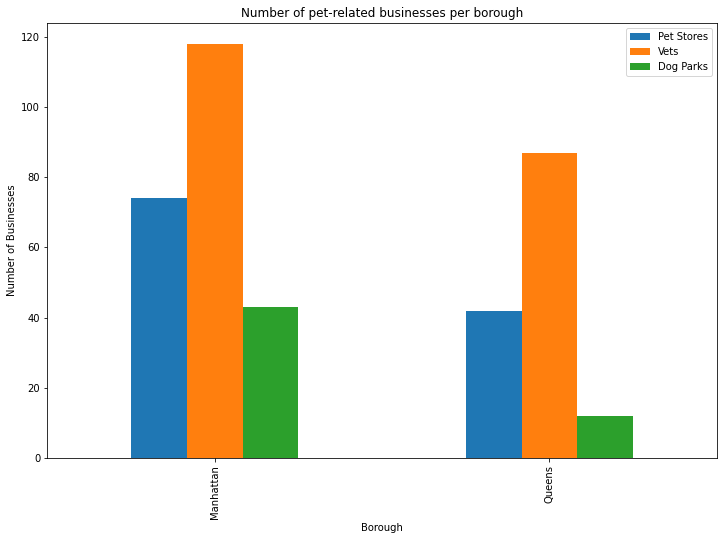

In [24]:
# Barchart for pet related businesses in NYC and Queens
ax = df.plot.bar(x='Boroughs', figsize = (12,8))
ax.set(xlabel = 'Borough', ylabel = 'Number of Businesses', title = "Number of pet-related businesses per borough")

In [25]:
# Getting the num of bus per rating and the percentages for each rating (Manhattan)
PetStores_Manhattan_DF.groupby('rating')
MHTN_rating_count = PetStores_Manhattan_DF.value_counts('rating').to_frame()
MHTN_rating_count.columns = ['Num. of Businesses_MHTN']
MHTN_rating_count['rating_col'] = MHTN_rating_count.index
MHTN_rating_count['MHTNpercentages'] = round(100*(MHTN_rating_count['Num. of Businesses_MHTN']/MHTN_rating_count['Num. of Businesses_MHTN'].sum()),2)
MHTN_rating_count

,Num. of Businesses_MHTN,rating_col,MHTNpercentages
rating,,,
4.5,21,4.5,28.38
3.5,12,3.5,16.22
4.0,11,4.0,14.86
3.0,8,3.0,10.81
2.0,7,2.0,9.46
5.0,7,5.0,9.46
1.0,3,1.0,4.05
2.5,3,2.5,4.05
1.5,2,1.5,2.70


In [26]:
# Same as above but for Queens
PetStores_Queens_DF.groupby('rating')
queens_rating_count = PetStores_Queens_DF.value_counts('rating').to_frame()
queens_rating_count.columns = ['Num. of Businesses_qns']
queens_rating_count['rating_col'] = queens_rating_count.index
queens_rating_count['QNSpercentages'] = round(100*(queens_rating_count['Num. of Businesses_qns']/queens_rating_count['Num. of Businesses_qns'].sum()),2)
queens_rating_count

,Num. of Businesses_qns,rating_col,QNSpercentages
rating,,,
4.5,10,4.5,23.81
4.0,7,4.0,16.67
5.0,6,5.0,14.29
2.0,5,2.0,11.90
2.5,4,2.5,9.52
3.0,4,3.0,9.52
3.5,4,3.5,9.52
1.0,1,1.0,2.38
1.5,1,1.5,2.38


In [27]:
# Merges the two tables
both_rating_counts = pd.merge(MHTN_rating_count, queens_rating_count, how = 'outer')
both_rating_counts

,Num. of Businesses_MHTN,rating_col,MHTNpercentages,Num. of Businesses_qns,QNSpercentages
0,21,4.5,28.38,10,23.81
1,12,3.5,16.22,4,9.52
2,11,4.0,14.86,7,16.67
3,8,3.0,10.81,4,9.52
4,7,2.0,9.46,5,11.90
5,7,5.0,9.46,6,14.29
6,3,1.0,4.05,1,2.38
7,3,2.5,4.05,4,9.52
8,2,1.5,2.70,1,2.38


[Text(0.5, 0, 'Rating'),
 Text(0, 0.5, 'Percentage'),
 Text(0.5, 1.0, 'Percentage of Businesses with a given rating')]

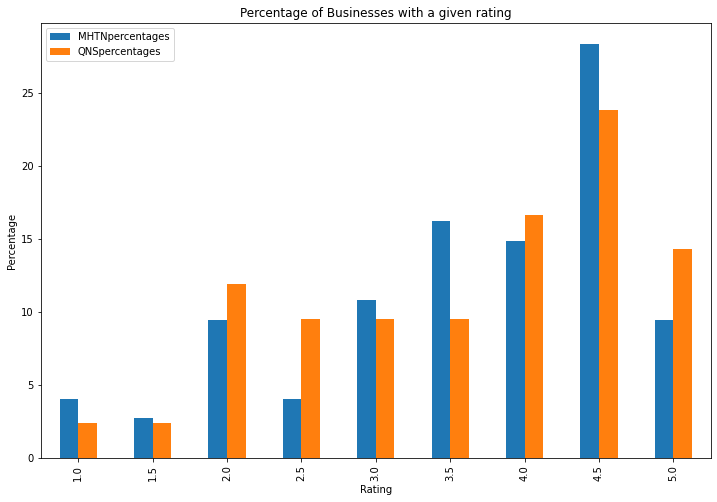

In [28]:
# Creates a bar chart for each rating percentage
both_rating_counts_forgraph=both_rating_counts[['rating_col','MHTNpercentages', 'QNSpercentages']]
both_rating_counts_forgraph = both_rating_counts_forgraph.sort_values('rating_col')
ax = both_rating_counts_forgraph.plot.bar(x='rating_col', figsize = (12,8))
ax.set(xlabel = 'Rating', ylabel = 'Percentage', title = 'Percentage of Businesses with a given rating')

In [31]:
# Opens relative csv files as dataframes and the need columns 
zipcodesinqueenscounty = pd.read_csv('./csv/QueensZipCodes.csv')[['Zip', 'Household_Income', 'Population']]
zipcodesinNYcounty = pd.read_csv('./csv/ManhattanZipCodes.csv')[['Zip', 'Household_Income', 'Population']]

In [32]:
# Drops any blank values
zipcodesinqueenscounty = zipcodesinqueenscounty.dropna()

In [33]:
# Sets the index to zip for the data frame
zipcodesinqueenscounty = zipcodesinqueenscounty.set_index('Zip')

In [34]:
# Counts the zip codes for each dataframe
PetStore_Queens_DF = PetStores_Queens_DF.groupby('zip_code').count()
Vets_Queens_DF = Vets_Queens_DF.groupby('zip_code').count()
DogParks_Queens_DF = DogParks_Queens_DF.groupby('zip_code').count()

In [35]:
# Merges the relevant tables selects 
Queens_Counts = zipcodesinqueenscounty.join(PetStore_Queens_DF, how='outer')
Queens_Counts = Queens_Counts[['Household_Income', 'Population', 'url']]
Queens_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores']

Queens_Counts = Queens_Counts.join(Vets_Queens_DF, how='outer')
Queens_Counts = Queens_Counts[['Household_Income', 'Population', 'No. of Pet Stores', 'url']]
Queens_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores', 'No. of Vets']

Queens_Counts = Queens_Counts.join(DogParks_Queens_DF, how='outer')
Queens_Counts = Queens_Counts[['Household_Income', 'Population', 'No. of Pet Stores','No. of Vets',
                               'url']]
Queens_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores', 'No. of Vets',
                        'No. of Dog Parks']

Queens_Counts['Store to Vet ratio'] = Queens_Counts['No. of Pet Stores']/Queens_Counts['No. of Vets']

Queens_Counts = Queens_Counts.sort_values('Household_Income', ascending = False).fillna(0)

Queens_Counts['Population'] = Queens_Counts['Population'].astype(str).astype(int)
Queens_Counts['Household_Income'] = Queens_Counts['Household_Income'].astype(str).astype(int)

Note the low population of 11430 - this is JFK's ZipCode - let's ignore this row.

Of the other four wealthiest neighborhoods in Queens, only 2 have pet stores.

In [36]:
zipcodesinqueenscounty['Population'] = zipcodesinqueenscounty['Population'].astype(str).astype(int)
zipcodesinqueenscounty['Household_Income'] = zipcodesinqueenscounty['Household_Income'].astype(str).astype(int)

In [37]:
capita_per_petstore_queens = zipcodesinqueenscounty['Population'].sum()/len(PetStores_Queens_DF)
round(capita_per_petstore_queens,-1)

53270.0

In Queens generally, there is one pet store per 53,270 people, which indicates that these top four neighbourhoods are overserved.

Let's do the same analysis for Manhattan:

In [38]:
zipcodesinNYcounty = zipcodesinNYcounty.dropna()
zipcodesinNYcounty = zipcodesinNYcounty.set_index('Zip')

In [39]:
PetStore_Manhattan_DF = PetStores_Manhattan_DF.groupby('zip_code').count()

In [40]:
zipcodesinNYcounty.join(PetStore_Manhattan_DF, how='outer').sort_values('Household_Income', ascending = False).head()

,Household_Income,Population,business_id,business_alias,business_name,is_closed,url,review_count,category1,rating,longitude,latitude
10007,112947.0,3522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10280,108536.0,6614.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10162,108416.0,1726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,101868.0,1225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10069,88091.0,1403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
capita_per_petstore_NY = zipcodesinNYcounty['Population'].sum()/len(PetStores_Manhattan_DF)
capita_per_petstore_NY

20224.432432432433


Let's find out if Queens is served by more larger pet stores than Manhattan:

In [42]:
PetStores_Queens_DF.groupby('business_name').count().sort_values('url', ascending = False).head()

,business_id,business_alias,is_closed,url,review_count,category1,rating,longitude,latitude,zip_code
business_name,,,,,,,,,,
Petco,3,3,3,3,3,3,3,3,3,3
Astoria Pets,1,1,1,1,1,1,1,1,1,1
Best Pet Supplies,1,1,1,1,1,1,1,1,1,1
Pets Unlimited Ltd,1,1,1,1,1,1,1,1,1,1
Puppy Paws,1,1,1,1,1,1,1,1,1,1


In [43]:
PetStores_Manhattan_DF.groupby('business_name').count().sort_values('url', ascending = False).head()

,business_id,business_alias,is_closed,url,review_count,category1,rating,longitude,latitude,zip_code
business_name,,,,,,,,,,
Pet Central,7,7,7,7,7,7,7,7,7,7
Petco,4,4,4,4,4,4,4,4,4,4
Petopia,4,4,4,4,4,4,4,4,4,4
Pamper Ur Pets,2,2,2,2,2,2,2,2,2,2
Love Thy Beast,2,2,2,2,2,2,2,2,2,2


Note evidence that only one fifth of New Yorkers license their dogs - data around this may be unhelpful, and outdated, given the significant uptick in pet ownership since the beginning of the pandemic.






In [44]:
PetStore_Manhattan_DF = PetStores_Manhattan_DF.groupby('zip_code').count()
Vets_Manhattan_DF = Vets_Manhattan_DF.groupby('zip_code').count()
DogParks_Manhattan_DF = DogParks_Manhattan_DF.groupby('zip_code').count()

In [45]:
Manhattan_Counts = zipcodesinNYcounty.join(PetStore_Manhattan_DF, how='outer')
Manhattan_Counts = Manhattan_Counts[['Household_Income', 'Population', 'url']]

Manhattan_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores']



Manhattan_Counts = Manhattan_Counts.join(Vets_Manhattan_DF, how='outer')

Manhattan_Counts = Manhattan_Counts[['Household_Income', 'Population', 'No. of Pet Stores', 'url']]

Manhattan_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores', 'No. of Vets']

Manhattan_Counts = Manhattan_Counts.join(DogParks_Manhattan_DF, how='outer')

Manhattan_Counts = Manhattan_Counts[['Household_Income', 'Population', 'No. of Pet Stores','No. of Vets','url']]


Manhattan_Counts.columns = ['Household_Income', 'Population', 'No. of Pet Stores', 'No. of Vets',
                        'No. of Dog Parks']

Manhattan_Counts['Store to Vet ratio'] = Manhattan_Counts['No. of Pet Stores']/Manhattan_Counts['No. of Vets']


Manhattan_Counts = Manhattan_Counts.sort_values('Household_Income', ascending = False).fillna(0)


In [46]:
mhtn_corr = Manhattan_Counts['No. of Vets'].corr(Manhattan_Counts['No. of Pet Stores'])
mhtn_corr

0.7889475323530651

In [47]:
qns_corr = Queens_Counts['No. of Vets'].corr(Queens_Counts['No. of Pet Stores'])
qns_corr

0.43948179559005474

[Text(0.5, 0, 'No. of Vets'), Text(0.5, 1.0, 'Queens (corr = 0.44)')]

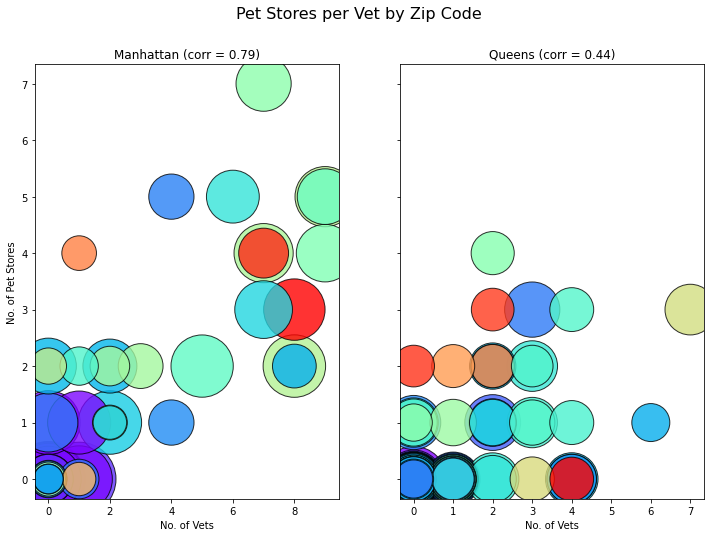

In [48]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,8), sharey = True)

ax2.scatter(Manhattan_Counts['No. of Vets'], Manhattan_Counts['No. of Pet Stores'], 
            s = 0.05*Manhattan_Counts['Household_Income'],
            c=Manhattan_Counts['Population'],
            cmap="rainbow", edgecolor = 'k', alpha = 0.8)
ax3.scatter(Queens_Counts['No. of Vets'], Queens_Counts['No. of Pet Stores'], 
            s = 0.05*(Queens_Counts['Household_Income']),
            c=Queens_Counts['Population'],
            cmap="rainbow", edgecolor = 'k', alpha = 0.8)

fig.suptitle('Pet Stores per Vet by Zip Code', fontsize=16)

ax2.set(xlabel = 'No. of Vets', ylabel = 'No. of Pet Stores', title = 'Manhattan (corr = 0.79)')
ax3.set(xlabel = 'No. of Vets', title = 'Queens (corr = 0.44)')

In [49]:
Manhattan_Counts_Has_Vet = Manhattan_Counts[Manhattan_Counts['No. of Vets'] >0]
Queens_Counts_Has_Vet = Queens_Counts[Queens_Counts['No. of Vets'] >0]

In [50]:
mhtn_corr_has_vets = Manhattan_Counts_Has_Vet['No. of Vets'].corr(Manhattan_Counts_Has_Vet['No. of Pet Stores'])
mhtn_corr_has_vets

0.6764212678203162

In [51]:
qns_corr_has_vets = Queens_Counts_Has_Vet['No. of Vets'].corr(Queens_Counts_Has_Vet['No. of Pet Stores'])
qns_corr_has_vets

0.2965600828435215

[Text(0.5, 0, 'No. of Vets'), Text(0.5, 1.0, 'Queens (corr = 0.30)')]

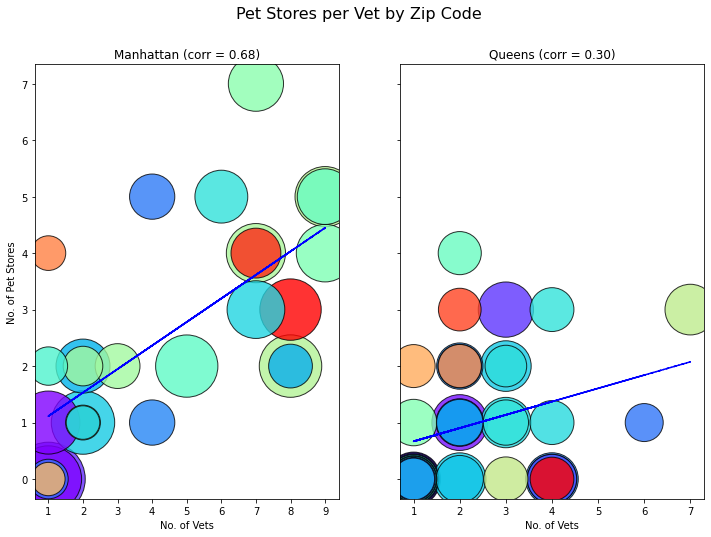

In [52]:
# Makes a graph for petstores per zipcode in the two bouroughs
import numpy as np

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(12,8), sharey = True)

z_Mhtn = np.polyfit(Manhattan_Counts_Has_Vet['No. of Vets'], 
               Manhattan_Counts_Has_Vet['No. of Pet Stores'], 1)

p_mhtn = np.poly1d(z_Mhtn)

z_qns = np.polyfit(Queens_Counts_Has_Vet['No. of Vets'], 
               Queens_Counts_Has_Vet['No. of Pet Stores'], 1)

p_qns = np.poly1d(z_qns)

ax4.scatter(Manhattan_Counts_Has_Vet['No. of Vets'], Manhattan_Counts_Has_Vet['No. of Pet Stores'], 
            s = 0.05*Manhattan_Counts_Has_Vet['Household_Income'],
            c=Manhattan_Counts_Has_Vet['Population'],
            cmap="rainbow", edgecolor = 'k', alpha = 0.8)

ax4.plot(Manhattan_Counts_Has_Vet['No. of Vets'],p_mhtn(Manhattan_Counts_Has_Vet['No. of Vets']),"b--")

ax5.scatter(Queens_Counts_Has_Vet['No. of Vets'], Queens_Counts_Has_Vet['No. of Pet Stores'], 
            s = 0.05*(Queens_Counts_Has_Vet['Household_Income']),
            c=Queens_Counts_Has_Vet['Population'],
            cmap="rainbow", edgecolor = 'k', alpha = 0.8)

ax5.plot(Queens_Counts_Has_Vet['No. of Vets'],p_qns(Queens_Counts_Has_Vet['No. of Vets']),"b--")


fig.suptitle('Pet Stores per Vet by Zip Code', fontsize=16)

ax4.set(xlabel = 'No. of Vets', ylabel = 'No. of Pet Stores', title = 'Manhattan (corr = 0.68)')
ax5.set(xlabel = 'No. of Vets', title = 'Queens (corr = 0.30)')